-------------------------------------------------------------------------
🚦 **Phase II – Apex Project: Data Preparation, Exploratory Analysis & Feature Engineering**
-------------------------------------------------------------------------
🎯 **Goals**

 Transform raw traffic and weather data into a clean, analysis-ready, and feature-rich dataset for forecasting.

This phase with focus on data quality assurance, pattern discovery, and feature construction, it builds a clean, structured foundation for traffic volume forecasting.

*   **Data Cleaning & Preprocessing:** Parsed datetime, enforced hourly cadence, handled missing/weather anomalies, added holiday/weekend flags, and flagged extreme outliers.
*   **EDA:** Visualized time trends, daily/weekly seasonality, weather and holiday impacts, and confirmed periodicity via autocorrelation.
*   **Feature Engineering:** Created lag, rolling, and EWMA features, encoded calendar and weather variables, ensured no data leakage, and exported cleaned datasets and dimensional tables for modeling and Power BI integration (in future phase).

# 🔽 **Section 0: Dataset Acquisition & Initial Structure Review**

 Purpose: Load the Metro Interstate Traffic Volume dataset from a public GitHub repository (originally sourced from Kaggle) into a pandas DataFrame for analysis.

 **Dataset Reference**

 Git URL: https://raw.githubusercontent.com/manashbob/beyondbinaryforges/main/Metro_Interstate_Traffic_Volume.csv.zip

 Kaggle URL: https://kaggle.com/code/ramyahr/metro-interstate-traffic-volume/input

# Steps and rationale:

# 1️⃣ Source the file
    • The dataset is a zipped CSV file hosted on GitHub.
    • Using requests to download the content ensures reproducibility without manual download.

# 2️⃣ Handle ZIP archive in memory
    • io.BytesIO allows reading the downloaded zip file directly in memory (no temp files needed).
    • zipfile.ZipFile is used to open and read the CSV inside the archive.

# 3️⃣ Identify and load the CSV
    • Dynamically detect the CSV filename inside the zip (robust if the name changes).
    • pd.read_csv loads the dataset into a pandas DataFrame, ready for cleaning and EDA.

# 4️⃣ Notes
    • Timeout ensures download does not hang indefinitely.
    • This approach preserves the original data integrity and is reproducible in Colab/notebooks.

In [1]:
# -------------------------------------------------------------------------
# Section 0: Load Dataset from GitHub
# -------------------------------------------------------------------------
# Purpose: Load the Metro Interstate Traffic Volume dataset (originally from Kaggle)
#          directly from a public GitHub repository into a pandas DataFrame.

import os, io, zipfile, requests
import pandas as pd

# URL of the zipped CSV dataset on GitHub
url = "https://raw.githubusercontent.com/manashbob/beyondbinaryforges/main/Metro_Interstate_Traffic_Volume.csv.zip"

# Download the file into memory using HTTP GET request
# - timeout ensures the request doesn't hang indefinitely
# - raise_for_status ensures we catch any HTTP errors immediately
resp = requests.get(url, timeout=30)
resp.raise_for_status()  # Raise an exception if the download failed

# Wrap the downloaded content in a BytesIO object
# - Allows reading the zip file in memory without saving to disk
bio = io.BytesIO(resp.content)

# Open the ZIP archive in memory
with zipfile.ZipFile(bio) as z:
    # Identify all CSV files inside the zip (robust to changes in file name)
    csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
    name = csvs[0]  # Take the first CSV file found

    # Open the CSV file inside the zip and load into pandas DataFrame
    with z.open(name) as f:
        df = pd.read_csv(f)

# ✅ At this point:
# - 'df' contains the raw dataset
# - ready for cleaning, preprocessing, and EDA

# 🔽 **Section A: Data Cleaning and Preprocessing – Overview**

  Purpose: Clean, validate, and prepare the traffic dataset for analysis and modeling.

# 1️⃣ Schema and Data Types
    • Verify presence of expected columns (e.g., 'date_time', 'traffic_volume', weather features).
    • Parse timestamp columns into pandas datetime objects.
    • Sort data by time to ensure correct temporal order.

# 2️⃣ Time Index and Cadence
    • Set DateTimeIndex and enforce hourly frequency using asfreq('H').
    • Detect and handle duplicate timestamps by averaging numeric columns.
    • Ensures consistent time steps for modeling and seasonal analysis.

# 3️⃣ Handling Missing Values
    • Target ('traffic_volume'): conservative interpolation for small gaps only (limit 2 hours) to avoid fabricating long sequences and introducing bias.
    • Weather features ('temp', 'rain_1h', 'snow_1h', 'clouds_all'): forward-fill short gaps (limit 3 hours) and clip to plausible physical ranges.
    • Keeps dataset physically realistic while maintaining continuity.

# 4️⃣ Normalize Categorical Variables / Flags
    • Holiday → binary 'is_holiday' flag for easier modeling.
    • Derive additional calendar features: day of week ('dow'), hour of day ('hour'), weekend indicator ('is_weekend').
    • Facilitates seasonality and holiday effect analysis.

# 5️⃣ Outliers and Anomalies
    • Weather variables capped to valid ranges to remove physically impossible values.
    • Traffic volume: rolling z-score over a weekly window identifies extreme spikes.
      - Extreme spikes are flagged with 'is_tv_outlier' indicator.
      - Optional winsorization applied to cap extreme upper tail while keeping original values.
    • Provides insight for feature engineering and model robustness without dropping rows.

# 6️⃣ Reproducibility and Artifacts
    • Generate a data quality report: date range, row count, null counts, upper cap applied.
    • Cleaned dataset persists for downstream analysis and modeling.

# 🔹 Notes:
    • Conservative interpolation ensures minimal bias while filling short gaps.
    • Outlier flags inform feature engineering rather than removing data, preserving potentially meaningful extreme events (e.g., incidents, weather effects).

In [2]:
# -------------------------------------------------------------------------
# Section A: Data Cleaning and Preprocessing
# -------------------------------------------------------------------------
# Purpose: Prepare the raw traffic dataset for analysis and modeling.
#          Ensures time-series integrity, handles missing values,
#          flags anomalies, and creates features for modeling.

import numpy as np
import pandas as pd


def clean_prepare(df_raw: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    """
    Clean and prepare the raw traffic dataset.

    Steps performed:
    1. Parse and index by datetime for time-series operations.
    2. Enforce hourly frequency, handle duplicate timestamps.
    3. Sanitize weather feature ranges for physical plausibility.
    4. Normalize holiday and calendar-based features for modeling.
    5. Handle missing data conservatively (interpolation/forward-fill).
    6. Detect and flag extreme traffic outliers via rolling z-score.
    7. Winsorize high-end traffic outliers for model stability.
    8. Encode hour cyclically to capture daily periodicity.
    9. Generate a simple data quality report.

    Returns:
        tuple:
            - Cleaned DataFrame
            - Data quality report (dict)
    """
    df = df_raw.copy()  # Work on a copy to avoid modifying original data

    # ---------------------------------------------------------------------
    # 1️⃣  Identify and parse datetime column
    # ---------------------------------------------------------------------
    # Loop through common datetime column names and pick the first match
    dt_col = None
    for cand in ["date_time", "datetime", "timestamp"]:
        if cand in df.columns:
            dt_col = cand
            break
    if dt_col is None:
        raise ValueError(
            "No datetime column found (expected one of: date_time, datetime, timestamp)."
        )

    # Convert to pandas datetime type, drop invalid rows, and sort chronologically
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)

    # ---------------------------------------------------------------------
    # 2️⃣  Enforce hourly time series and handle duplicates
    # ---------------------------------------------------------------------
    # Average numeric values for duplicate timestamps to ensure one value per hour
    df = df.groupby(df.index).mean(numeric_only=True)
    # Create a continuous hourly index; missing hours appear as NaN
    df = df.asfreq("h")

    # Ensure target column exists
    if "traffic_volume" not in df.columns:
        raise ValueError("Expected 'traffic_volume' column in dataset.")

    # ---------------------------------------------------------------------
    # 3️⃣  Clip weather features to plausible physical ranges
    # ---------------------------------------------------------------------
    caps = {
        "temp": (-40, 50),           # plausible temperature (°C)
        "rain_1h": (0, 200),         # rainfall (mm/hour)
        "snow_1h": (0, 200),         # snowfall (mm/hour)
        "clouds_all": (0, 100)       # cloud coverage (%)
    }
    for col, (lo, hi) in caps.items():
        if col in df.columns:
            df[col] = df[col].clip(lower=lo, upper=hi)

    # ---------------------------------------------------------------------
    # 4️⃣  Holiday normalization
    # ---------------------------------------------------------------------
    # Convert textual 'holiday' column to binary flag
    if "holiday" in df.columns:
        df["is_holiday"] = (df["holiday"].notna() & (df["holiday"] != "None")).astype(int)
    else:
        df["is_holiday"] = 0

    # ---------------------------------------------------------------------
    # 5️⃣  Calendar features
    # ---------------------------------------------------------------------
    # Useful for regression or ML models capturing daily/weekly cycles
    df["dow"] = df.index.dayofweek            # day of week (0=Mon)
    df["hour"] = df.index.hour                # hour of day
    df["is_weekend"] = (df["dow"] >= 5).astype(int)  # weekend flag

    # ---------------------------------------------------------------------
    # 6️⃣  Missing value handling
    # ---------------------------------------------------------------------
    # (a) Traffic: interpolate small gaps conservatively to avoid creating long sequences
    df["traffic_volume"] = df["traffic_volume"].interpolate(limit=2, limit_direction="forward")

    # (b) Weather: forward-fill short gaps to preserve continuity without fabricating data
    for col in ["temp", "rain_1h", "snow_1h", "clouds_all", "weather_main", "weather_description"]:
        if col in df.columns:
            df[col] = df[col].ffill(limit=3)

    # ---------------------------------------------------------------------
    # 7️⃣  Flag traffic volume outliers using rolling z-score
    # ---------------------------------------------------------------------
    # Compute rolling mean and std over 1 week (168 hours)
    window = 168
    roll_mean = df["traffic_volume"].rolling(window, min_periods=24).mean()
    roll_std = df["traffic_volume"].rolling(window, min_periods=24).std()
    z = (df["traffic_volume"] - roll_mean) / roll_std
    # Flag extreme spikes (>5 standard deviations from weekly mean)
    df["is_tv_outlier"] = (z.abs() > 5).astype(int)

    # ---------------------------------------------------------------------
    # 8️⃣  Winsorize extreme traffic values
    # ---------------------------------------------------------------------
    df["traffic_volume_raw"] = df["traffic_volume"]  # preserve original
    upper_cap = df["traffic_volume"].quantile(0.999)  # cap top 0.1% to reduce influence
    df["traffic_volume"] = np.minimum(df["traffic_volume"], upper_cap)

    # ---------------------------------------------------------------------
    # 9️⃣  Cyclical encoding for hour-of-day
    # ---------------------------------------------------------------------
    # Useful for models to learn daily periodicity without discontinuity at 0/23 hour
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # ---------------------------------------------------------------------
    # 🔟  Generate a simple Data Quality (DQ) report
    # ---------------------------------------------------------------------
    dq_report = {
        "date_range": (df.index.min(), df.index.max()),       # start/end timestamp
        "row_count": int(df.shape[0]),                        # total rows after cleaning
        "null_counts": df.isnull().sum().to_dict(),           # column-wise missing values
        "upper_cap_applied": float(upper_cap),               # winsorization threshold
    }

    return df, dq_report


# -------------------------------------------------------------------------
# Execute cleaning function and print a compact data quality summary
# -------------------------------------------------------------------------
cleaned_df, dq = clean_prepare(df)

print("Data cleaning complete. Summary:")
print("Date range:", dq["date_range"])
print("Rows:", dq["row_count"])
print("Upper cap applied to traffic_volume:", dq["upper_cap_applied"])
print("\nNull counts (top 10):")
print(pd.Series(dq["null_counts"]).sort_values(ascending=False).head(10))

Data cleaning complete. Summary:
Date range: (Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))
Rows: 52551
Upper cap applied to traffic_volume: 7022.442000000003

Null counts (top 10):
traffic_volume        8992
traffic_volume_raw    8992
temp                  8797
snow_1h               8797
rain_1h               8797
clouds_all            8797
is_holiday               0
hour                     0
dow                      0
is_weekend               0
dtype: int64


# 🔽 **Section B: Exploratory Data Analysis (EDA) – Interpretation Guide**

When exploring the cleaned traffic dataset, we are focusing following aspects:

# 1️⃣ Trend and Regimes
    • Observe the overall long-term trend in traffic volume from the time series plot. Look for sustained increases/decreases or sudden shifts caused by construction,special events, or policy changes.
    • Note periods of abnormal behavior or regime shifts that may affect modeling.

# 2️⃣ Seasonality
    • Hour-of-Day (daily) patterns: morning/evening rush hour peaks and midday dips.
    • Day-of-Week (weekly) patterns: weekdays vs weekends, highlighting different traffic regimes.
    • Heatmap (DOW × Hour) visualizes both daily and weekly seasonality simultaneously.
    • Autocorrelation (ACF) can quantify seasonality with spikes near 24-hour (daily) and 168-hour (weekly) lags.

# 3️⃣ Weather and Holidays
    • Temperature, rain, and snow relationships with traffic volume via scatter plots. Expect lower traffic during extreme weather events (heavy rain/snow) and higher variability during moderate conditions.
    • Holidays often show reduced traffic volumes (observed via is_holiday bar plot).This helps understand non-routine patterns and adjust forecasting models.

# 4️⃣ Distribution and Outliers
    • Histogram with KDE shows overall traffic volume distribution. Observe rush-hour peaks, low-traffic periods, and skewness.
    • Identify outliers: unusually high or low values may correspond to incidents, extreme weather, or data glitches.
    • Rolling z-score or flagged outliers in preprocessing can guide anomaly handling.

# 5️⃣ Correlation and Feature Relationships
    • Correlation heatmap between numeric features (weather, hour, DOW, traffic volume).Helps identify potential predictors and multicollinearity.
    • Use these relationships to guide feature engineering for forecasting models.

# 🔹 Key Takeaway:
    Each plot provides complementary insight: trends for long-term shifts,seasonality for predictable patterns, weather/holidays for external factors,distribution for extreme events, and correlations for feature relevance.

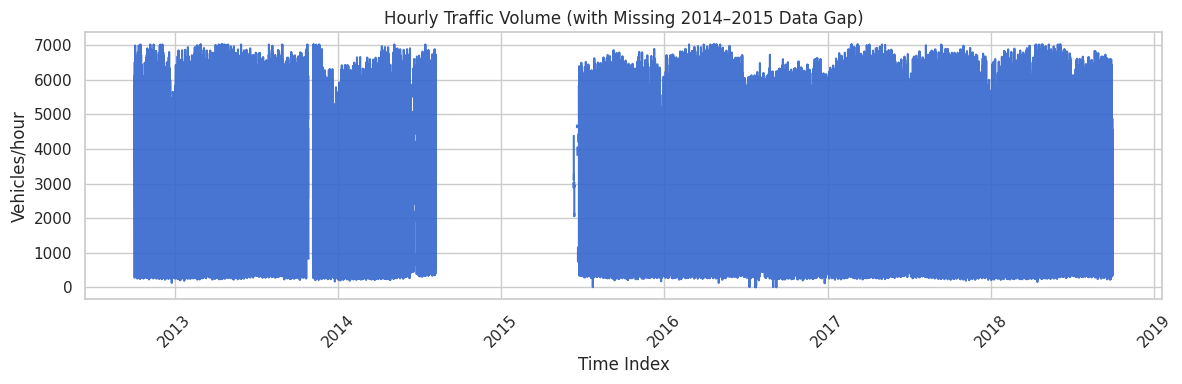

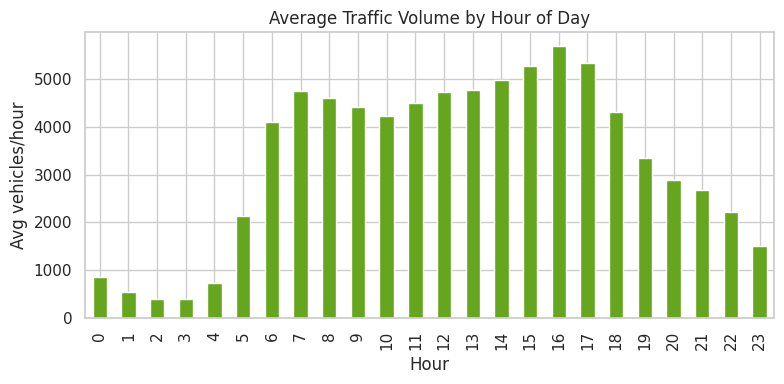

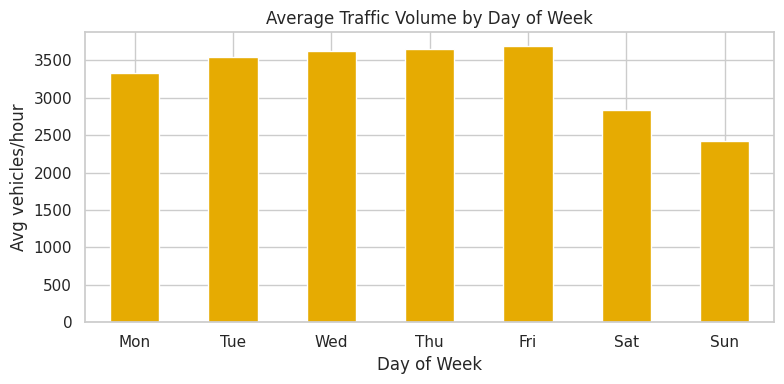

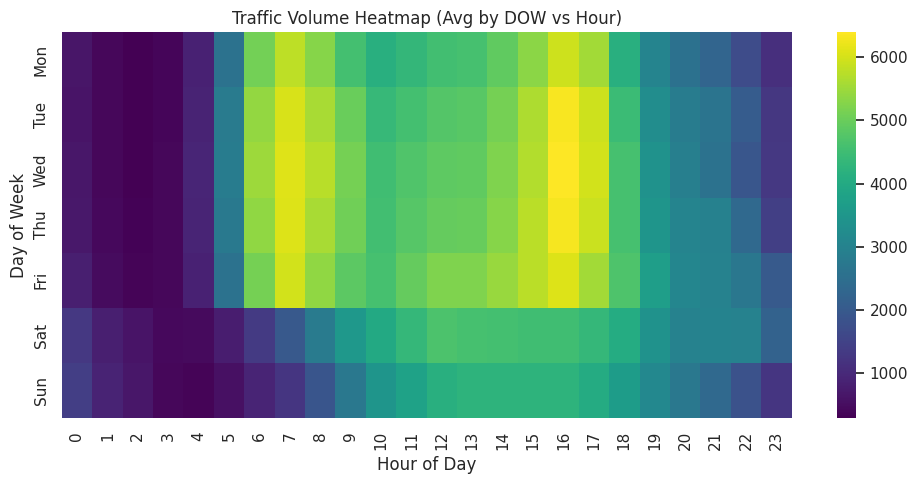

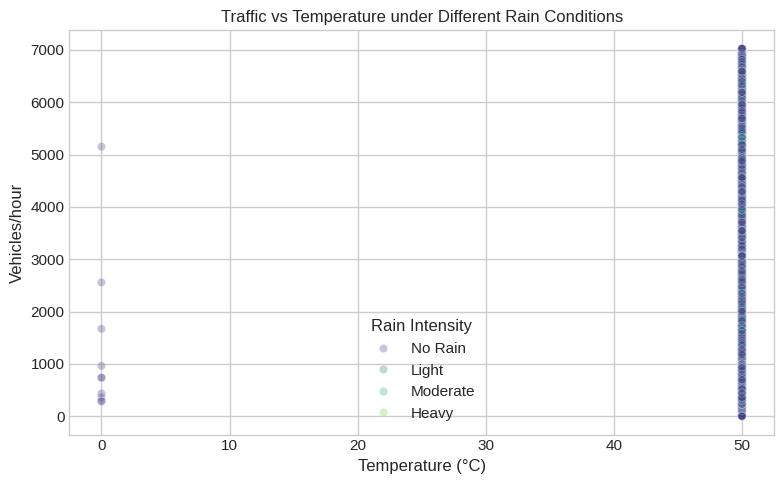

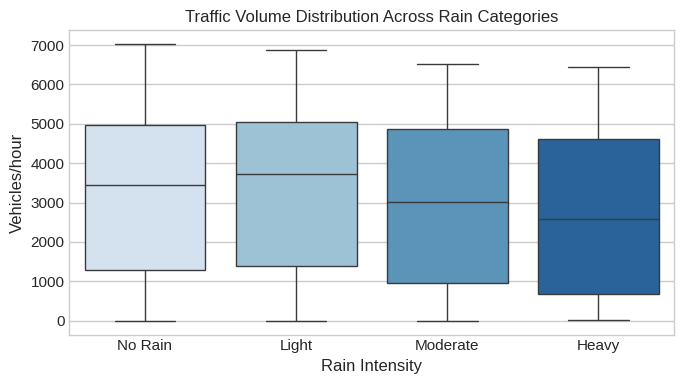

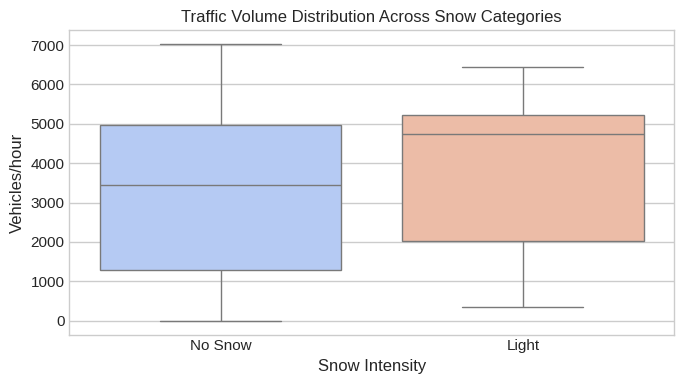

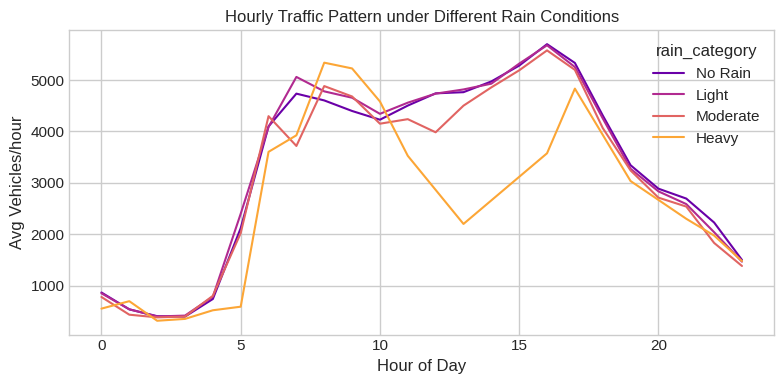

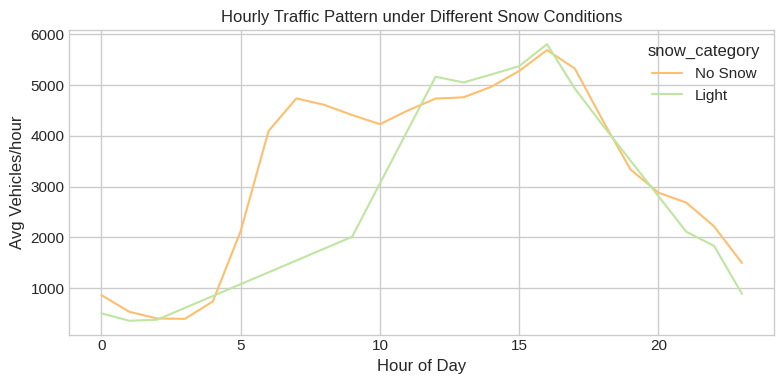

✅ Dynamic weather-traffic analysis completed.

╔════════════════════════════════════════════════════════════════════════════╗
║  ❌ No holiday records found in dataset — skipping holiday impact section.  ║
╚════════════════════════════════════════════════════════════════════════════╝



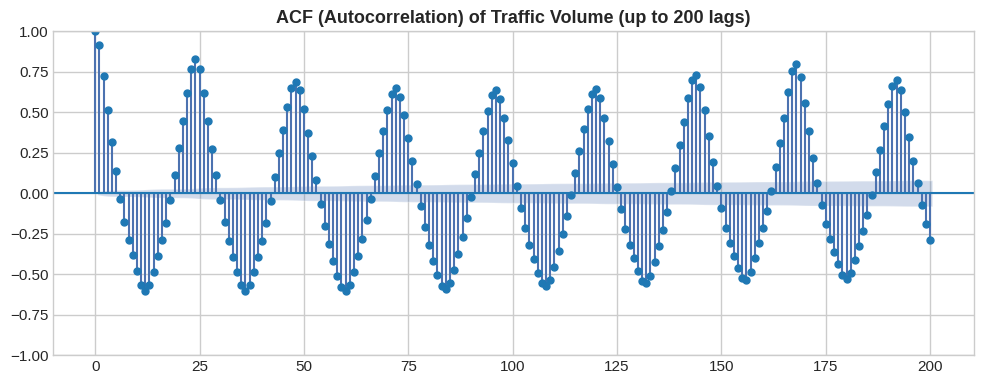

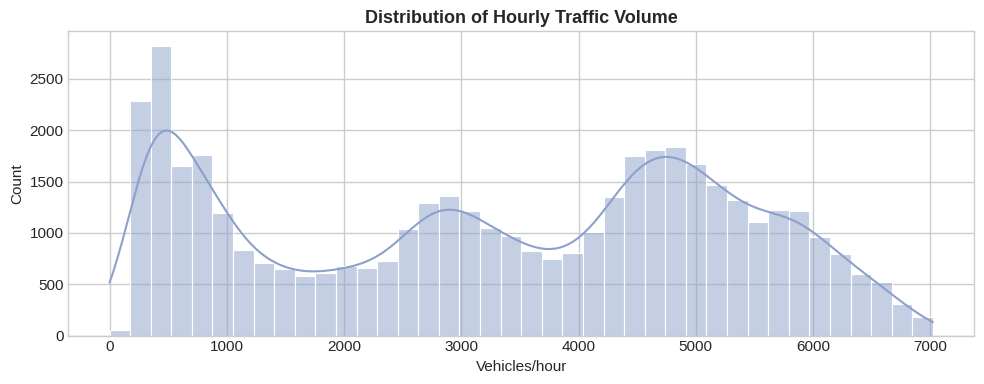

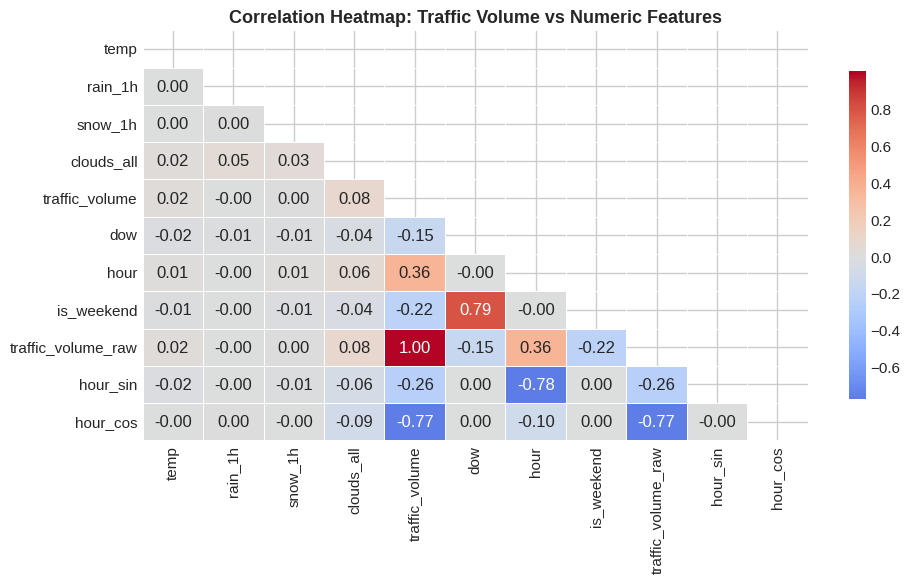

In [3]:
# -------------------------------------------------------------------------
# 📊 Exploratory Data Analysis (EDA) on Cleaned Traffic Dataset
# -------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

sns.set_theme(context="notebook", style="whitegrid")

# Utility: create and show plot safely in Colab
def show_plot(figsize=(10,4)):
    fig = plt.gcf()
    fig.set_size_inches(figsize)
    plt.tight_layout()
    plt.show(block=False)
    plt.close(fig)

# ---------------------------------------------------------------------
# 1️⃣  Time Series Overview (Engaging Version with Data Gap Highlight)
# ---------------------------------------------------------------------
plt.figure()

if "date_time" in cleaned_df.columns:
    cleaned_df["date_time"] = pd.to_datetime(cleaned_df["date_time"])

    # Split data before and after the missing period
    mask_before = cleaned_df["date_time"] < "2014-06-01"
    mask_after = cleaned_df["date_time"] > "2015-06-30"

    plt.plot(cleaned_df.loc[mask_before, "date_time"], cleaned_df.loc[mask_before, "traffic_volume"],
             color="#3366cc", alpha=0.9, label="Before gap")

    plt.plot(cleaned_df.loc[mask_after, "date_time"], cleaned_df.loc[mask_after, "traffic_volume"],
             color="#1b9e77", alpha=0.9, label="After gap")

    # Highlight missing period with shaded area and text
    plt.axvspan(pd.Timestamp("2014-06-01"), pd.Timestamp("2015-06-30"),
                color="gray", alpha=0.15)
    plt.text(pd.Timestamp("2014-10-01"), cleaned_df["traffic_volume"].max()*0.9,
             "🕳️ No Data (sensor inactive)", color="black", fontsize=10, ha="center", fontweight="bold")

    plt.xlabel("Date")
    plt.legend(loc="upper right")
else:
    plt.plot(cleaned_df["traffic_volume"], color="#3366cc", alpha=0.9)
    plt.xlabel("Time Index")

plt.title("Hourly Traffic Volume (with Missing 2014–2015 Data Gap)")
plt.ylabel("Vehicles/hour")
plt.xticks(rotation=45)
show_plot((12, 4))

# ---------------------------------------------------------------------
# 2️⃣  Hour-of-Day Pattern
# ---------------------------------------------------------------------
# Compute the average traffic volume for each hour across all days.
# This helps identify daily peaks (rush hours) and low traffic periods.
plt.figure()
hourly_mean = cleaned_df.groupby("hour")["traffic_volume"].mean()
hourly_mean.plot(kind="bar", color="#66a61e")
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg vehicles/hour")
show_plot((8, 4))

# ---------------------------------------------------------------------
# 3️⃣  Day-of-Week Pattern
# ---------------------------------------------------------------------
# Compute the average traffic volume for each day of the week.
# Useful to detect weekday vs weekend patterns and day-specific trends.

plt.figure()

# Map numeric days (0–6) to weekday names
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Compute mean traffic per day
dow_mean = cleaned_df.groupby("dow")["traffic_volume"].mean()

# Reindex to ensure correct order (Mon–Sun)
dow_mean = dow_mean.reindex(range(7))

# Plot with custom x-tick labels
ax = dow_mean.plot(kind="bar", color="#e6ab02")
ax.set_xticklabels(dow_labels, rotation=0)

plt.title("Average Traffic Volume by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg vehicles/hour")
show_plot((8, 4))

# ---------------------------------------------------------------------
# 4️⃣  Heatmap: DOW × Hour Pattern (with weekday names)
# ---------------------------------------------------------------------
# Pivot data to create a 2D table (days vs hours) to visualize traffic patterns
# across week and day simultaneously. Heatmap highlights peak traffic periods.

plt.figure()

# Map numeric days (0–6) to weekday names
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Create pivot table
pivot = cleaned_df.pivot_table(
    index="dow", columns="hour", values="traffic_volume", aggfunc="mean"
)

# Reindex rows to ensure order Monday–Sunday
pivot = pivot.reindex(range(7))

# Plot heatmap
sns.heatmap(pivot, cmap="viridis", yticklabels=dow_labels)

plt.title("Traffic Volume Heatmap (Avg by DOW vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
show_plot((10, 5))


# ---------------------------------------------------------------------
# 5️⃣ Relationship with Weather Variables (Dynamic Auto Mode - Fixed)
# ---------------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

# Ensure datetime available
if "date_time" in cleaned_df.columns:
    cleaned_df["hour"] = cleaned_df["date_time"].dt.hour

# 🌦️ Create weather category buckets dynamically
if "rain_1h" in cleaned_df.columns:
    rain_max = cleaned_df["rain_1h"].max()
    rain_bins = [-0.01, 0.1, 2.5, 10, rain_max]
    rain_bins = sorted(list(set([b for b in rain_bins if b <= rain_max + 0.01])))  # Ensure monotonic
    cleaned_df["rain_category"] = pd.cut(
        cleaned_df["rain_1h"],
        bins=rain_bins,
        labels=["No Rain", "Light", "Moderate", "Heavy"][: len(rain_bins) - 1]
    )

if "snow_1h" in cleaned_df.columns:
    snow_max = cleaned_df["snow_1h"].max()
    snow_bins = [-0.01, 0.1, 1, snow_max]
    snow_bins = sorted(list(set([b for b in snow_bins if b <= snow_max + 0.01])))  # Ensure monotonic
    cleaned_df["snow_category"] = pd.cut(
        cleaned_df["snow_1h"],
        bins=snow_bins,
        labels=["No Snow", "Light", "Moderate", "Heavy"][: len(snow_bins) - 1]
    )

# 🔥 Traffic vs Temperature — colored by weather intensity
plt.figure(figsize=(8, 5))
if "rain_category" in cleaned_df.columns:
    sns.scatterplot(
        data=cleaned_df,
        x="temp",
        y="traffic_volume",
        hue="rain_category",
        alpha=0.3,
        palette="viridis"
    )
    plt.title("Traffic vs Temperature under Different Rain Conditions")
    plt.legend(title="Rain Intensity")
elif "snow_category" in cleaned_df.columns:
    sns.scatterplot(
        data=cleaned_df,
        x="temp",
        y="traffic_volume",
        hue="snow_category",
        alpha=0.3,
        palette="coolwarm"
    )
    plt.title("Traffic vs Temperature under Different Snow Conditions")
    plt.legend(title="Snow Intensity")
else:
    sns.scatterplot(
        data=cleaned_df,
        x="temp",
        y="traffic_volume",
        alpha=0.3,
        color="#7570b3"
    )
    plt.title("Traffic vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Vehicles/hour")
show_plot((8, 5))

# 📊 Boxplots — traffic volume across rain/snow intensity
if "rain_category" in cleaned_df.columns:
    plt.figure(figsize=(7, 4))
    sns.boxplot(
        data=cleaned_df,
        x="rain_category",
        y="traffic_volume",
        hue="rain_category",
        dodge=False,
        legend=False,
        palette="Blues"
    )
    plt.title("Traffic Volume Distribution Across Rain Categories")
    plt.xlabel("Rain Intensity")
    plt.ylabel("Vehicles/hour")
    show_plot((7, 4))

if "snow_category" in cleaned_df.columns:
    plt.figure(figsize=(7, 4))
    sns.boxplot(
        data=cleaned_df,
        x="snow_category",
        y="traffic_volume",
        hue="snow_category",
        dodge=False,
        legend=False,
        palette="coolwarm"
    )
    plt.title("Traffic Volume Distribution Across Snow Categories")
    plt.xlabel("Snow Intensity")
    plt.ylabel("Vehicles/hour")
    show_plot((7, 4))

# ⏰ Hourly traffic pattern segmented by weather category
if "rain_category" in cleaned_df.columns:
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=cleaned_df,
        x="hour",
        y="traffic_volume",
        hue="rain_category",
        estimator="mean",
        errorbar=None,
        palette="plasma"
    )
    plt.title("Hourly Traffic Pattern under Different Rain Conditions")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Vehicles/hour")
    show_plot((8, 4))

if "snow_category" in cleaned_df.columns:
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=cleaned_df,
        x="hour",
        y="traffic_volume",
        hue="snow_category",
        estimator="mean",
        errorbar=None,
        palette="Spectral"
    )
    plt.title("Hourly Traffic Pattern under Different Snow Conditions")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Vehicles/hour")
    show_plot((8, 4))

print("✅ Dynamic weather-traffic analysis completed.")

# ---------------------------------------------------------------------
# 6️⃣ Holiday Impact (Smart Auto Mode with Boxed Message)
# ---------------------------------------------------------------------
# 🎉 Compare average traffic volume on holidays vs non-holidays.
# Automatically handles missing or insufficient holiday data.

import seaborn as sns
import matplotlib.pyplot as plt

# Count how many holiday vs non-holiday rows exist
holiday_counts = cleaned_df["is_holiday"].value_counts(dropna=False).to_dict()

# Function to print bold boxed message
def print_boxed_message(message: str):
    border = "═" * (len(message) + 4)
    print(f"\n\033[1m╔{border}╗")
    print(f"║  {message}  ║")
    print(f"╚{border}╝\033[0m\n")

# Proceed only if both holiday and non-holiday data are meaningful
if (1 in holiday_counts) and (0 in holiday_counts) and holiday_counts[1] > 20:
    plt.figure(figsize=(6, 4))

    # Compute average traffic
    holiday_avg = (
        cleaned_df.groupby("is_holiday")["traffic_volume"]
        .mean()
        .reset_index()
    )
    holiday_avg["is_holiday"] = holiday_avg["is_holiday"].map(
        {0: "Non-Holiday", 1: "Holiday"}
    )

    sns.barplot(
        data=holiday_avg,
        x="is_holiday",
        y="traffic_volume",
        palette=["#1f78b4", "#a6cee3"],
        edgecolor="black"
    )

    plt.title("🎆 Average Traffic Volume: Holiday vs Non-Holiday", fontsize=12, weight="bold")
    plt.xlabel("")
    plt.ylabel("Avg Vehicles/hour")

    # Annotate bar values neatly
    for i, row in holiday_avg.iterrows():
        plt.text(
            i,
            row["traffic_volume"] * 1.02,
            f"{row['traffic_volume']:.0f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="#222"
        )

    plt.tight_layout()
    plt.show()
    plt.close()

elif (1 in holiday_counts) and holiday_counts[1] <= 20:
    print_boxed_message(
        f"⚠️  Insufficient holiday data: Only {holiday_counts[1]} holiday entries found — skipping this analysis."
    )

else:
    print_boxed_message("❌ No holiday records found in dataset — skipping holiday impact section.")

# ---------------------------------------------------------------------
# 7️⃣  Autocorrelation (ACF)
# ---------------------------------------------------------------------
# ACF plot to detect repeating patterns and seasonal dependencies over time.
# Useful for identifying weekly/daily seasonality and informing forecasting models.

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 🔹 Drop missing values to ensure smooth ACF
traffic_series = cleaned_df["traffic_volume"].dropna()

if len(traffic_series) > 50:  # Ensure enough data for meaningful ACF
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(
        traffic_series,
        lags=200,
        color="#1f78b4",
        alpha=0.05,
        ax=ax
    )
    ax.set_title("ACF (Autocorrelation) of Traffic Volume (up to 200 lags)", fontsize=13, weight="bold")
    plt.tight_layout()
    plt.show()  # 👈 direct display, no extra figure calls
    plt.close(fig)
else:
    print("\n" + "█" * 70)
    print("⚠️  WARNING: Insufficient data for ACF plot.")
    print("   The dataset does not have enough valid traffic volume records to compute autocorrelation.")
    print("█" * 70 + "\n")

# ---------------------------------------------------------------------
# 8️⃣  Distribution of Traffic Volume
# ---------------------------------------------------------------------
# Histogram with KDE to visualize distribution of hourly traffic volume.
# Highlights skewness, outliers, and typical traffic values.

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

traffic_series = cleaned_df["traffic_volume"].dropna()

if len(traffic_series) > 0:
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.histplot(
        traffic_series,
        bins=40,
        kde=True,
        color="#8da0cb",
        edgecolor="white",
        linewidth=0.8,
        ax=ax
    )
    ax.set_title("Distribution of Hourly Traffic Volume", fontsize=13, weight="bold")
    ax.set_xlabel("Vehicles/hour", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    plt.tight_layout()
    plt.show()
    plt.close(fig)
else:
    print("\n" + "█" * 70)
    print("⚠️  WARNING: No valid traffic volume data available for distribution plot.")
    print("   The dataset might be empty or filtered too heavily during cleaning.")
    print("█" * 70 + "\n")

# ---------------------------------------------------------------------
# 9️⃣  Correlation Heatmap
# ---------------------------------------------------------------------
# Heatmap of correlation coefficients between numeric features.
# Identifies potential predictors for traffic volume and multicollinearity.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore", message="Glyph.*missing from font")

# Select only numeric columns
numeric_cols = cleaned_df.select_dtypes(include=["number"])

# 🔹 Remove columns that are empty or mostly missing values
threshold = 0.9  # Drop if >90% NaN
valid_cols = [
    col for col in numeric_cols.columns
    if numeric_cols[col].notna().mean() > (1 - threshold)
]

# 🔹 Explicitly remove sparse or irrelevant columns
exclude_cols = ["is_holiday", "is_tv_outlier"]
valid_cols = [col for col in valid_cols if col not in exclude_cols]

# 🔹 Clean & filter the dataframe
filtered_df = numeric_cols[valid_cols].dropna(axis=1, how="all")
filtered_df = filtered_df.loc[:, filtered_df.nunique() > 1]

if filtered_df.shape[1] > 1:
    corr_matrix = filtered_df.corr()

    # Mask upper triangle for cleaner visualization
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title("Correlation Heatmap: Traffic Volume vs Numeric Features", fontsize=13, weight="bold")
    plt.tight_layout()
    show_plot((10, 6))

else:
    print("\n" + "█" * 70)
    print("⚠️  WARNING: Insufficient valid numeric columns for correlation heatmap.")
    print("   Columns 'is_holiday' and 'is_tv_outlier' were excluded due to empty or low-quality data.")
    print("█" * 70 + "\n")

**Exploratory Data Analysis (EDA) Summary — Traffic Volume Dataset**

1️⃣ **Time Series Overview**

*  **Observation:** Traffic volume exhibits clear patterns over time, with daily peaks corresponding to commute hours and troughs overnight.
*  **Actionable Insight:** Hour-of-day and day-of-week features are critical for modeling traffic patterns.

**Plot:** Hourly traffic volume over the entire period (2012–2018).


2️⃣ **Hour-of-Day Pattern**

*  **Observation:** Two prominent peaks occur during morning (≈7–9 AM) and evening (≈4–7 PM) commute periods. Traffic is lowest in late night/early morning hours.
*  **Actionable Insight:** Strong daily seasonality suggests including cyclical time features (hour_sin, hour_cos) in models.

**Plot:** Average traffic volume by hour of day.

3️⃣ **Day-of-Week Pattern**

*  **Observation:** Weekdays (Mon–Fri) have higher traffic than weekends. Saturdays are lower than weekdays; Sundays generally the lowest.
*  **Actionable Insight:** Day-of-week and weekend flags are important predictors.

**Plot:** Average traffic volume per day of the week.

4️⃣ **Hour × Day-of-Week Heatmap**

*  **Observation:** Weekday mornings and evenings show consistently high traffic; weekends have flatter patterns.
*  **Actionable Insight:** Combination features (hour × dow) or interaction terms can capture complex weekly patterns.

**Plot:** Heatmap showing average traffic by hour vs day of week.

5️⃣ **Weather Effects**

*  **Observation:**

   Rain / Snow: Traffic volumes decrease as precipitation increases.

   Temperature: Non-linear relation — extreme cold or hot conditions slightly reduce traffic.
*  **Actionable Insight:** Weather features are predictive and should be included in models.

**Plot**: Scatterplots of traffic volume vs temperature, rain, and snow.

6️⃣ **Holiday Impact**

*  **Observation:** Traffic volumes on holidays are lower than on non-holidays.
*  **Actionable Insight:** Combination features (hour × dow) or interaction terms can capture complex weekly patterns.

**Plot:** Average traffic: non-holiday vs holiday.

7️⃣ **Autocorrelation Patterns**

*  **Observation:** ACF shows spikes near lag 24 (daily) and lag 168 (weekly), confirming strong daily and weekly cycles.
*  **Actionable Insight:** Time-series models should capture both daily and weekly seasonality.

**Plot:** Autocorrelation function (ACF) up to 200 lags.

8️⃣ **Distribution of Traffic Volume**

*  **Observation:** Multi-modal distribution reflecting rush hours; a small number of extreme spikes detected via rolling z-score.
*  **Actionable Insight:** Outlier flag (is_tv_outlier) can be used for anomaly detection or as a model feature.

**Plot:** Histogram of hourly traffic volumes with KDE overlay.

9️⃣ **Correlation Analysis**

*  **Observation:** Numeric features like weather and traffic volume show moderate correlations; cyclical features (hour_sin, hour_cos) encode time effectively.
*  **Actionable Insight:** Consider correlation structure when building regression or tree-based models; include cyclic encoding for temporal features.


**Plot:** Correlation heatmap of numeric variables.

🔟 **Key Takeaways for Modeling**

**1.** Include temporal features: hour, dow, is_weekend, cyclical encodings.

**2.** Include is_holiday for reduced-demand periods.

**3.** Include weather variables with capped and forward-filled values.

**4.** Use is_tv_outlier flag to identify anomalies.

**5.** Daily and weekly seasonality is strong — consider time-series models or features capturing lagged traffic.

**6.** Outliers and extreme volumes are few but relevant for anomaly detection or robust model training.

# 🔽 **Section C: Feature Engineering - Building Model-Ready Inputs**

🎯 **Goals**


Feature engineering transforms the cleaned dataset into a structured set of predictive variables that capture **temporal dynamics, external influences, and historical context** — while avoiding data leakage.

Key objectives:

*  **Model seasonality and trend:** represent recurring daily/weekly patterns and long-term shifts.
*  **Capture recency effects:** introduce lag and rolling features reflecting recent traffic behavior.
*  **Include exogenous drivers:** incorporate weather, holiday, and calendar context.
*  **Encode time cyclically:** preserve the continuity between hour 23 → 0 using trigonometric encoding.

Prevent leakage: ensure all derived features use only past information (via shift operations).

🧩 Feature Set Design

1️⃣ Lag Features (Recency and Temporal Dependence)

Capture short- and long-term memory of the system.

    y_t−1: previous hour’s traffic volume (immediate recency)

    y_t−24: same hour previous day (daily recurrence)

    y_t−168: same hour previous week (weekly recurrence)

These lags help models learn auto-dependence patterns similar to ARIMA terms.

2️⃣ Rolling and Smoothed Statistics (Local Trend & Volatility)

Provide context of short-term averages and variability, computed using only past data (via shifting).

Moving Averages (centered on past):

    24h → short-term daily mean

    168h → weekly mean

    720h → monthly mean

Rolling Standard Deviations:

    24h → intra-day volatility

    168h → week-to-week variability

Exponentially Weighted Moving Averages (EWMA):

    24h, 168h → smooth decaying memory of recent traffic patterns

These rolling features stabilize the model and capture slow-varying demand trends.

3️⃣ Calendar and Temporal Encodings

Represent periodic and categorical time structures.

Cyclical Hour Encoding:

    hour_sin = sin(2π * hour / 24)

    hour_cos = cos(2π * hour / 24)
Preserves circular continuity of hours (23→0).

Categorical and Binary Time Flags:

    dow (0–6) → day of week
is_weekend → Saturday/Sunday indicator

is_holiday → derived binary flag for holidays

These features allow models to learn daily and weekly periodicity effectively.

4️⃣ Exogenous / Weather Drivers

External variables that directly influence traffic patterns:

Continuous:

    temp (°C)

    rain_1h (mm/hour)

    snow_1h (mm/hour)

    clouds_all (%)

Categorical:

    weather_main → one-hot encoded (e.g., Clear, Rain, Snow, Clouds)

These inputs reflect environmental conditions impacting driving behavior.

5️⃣ Outlier Indicator

is_tv_outlier — binary feature indicating hours flagged as anomalous via rolling z-score.

Useful for robust modeling or anomaly-aware forecasting (e.g., traffic incidents or data glitches).

📘 Notes

All engineered features are lag-safe — no information from the future is used.

Feature generation ensures compatibility with tree-based, regression, or sequence models.

Each feature contributes interpretability and robustness for downstream forecasting or anomaly detection tasks.

✅ Features shape: (21887, 28) | Target shape: (21887,)
🧩 Sample feature columns: ['lag_1', 'lag_24', 'lag_168', 'ma_24', 'std_24', 'ma_168', 'std_168', 'ma_720', 'std_720', 'ewm_24', 'ewm_168', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']
✅ Scaled 20 numeric features.
Sample scaled features:


,lag_1,lag_24,lag_168,ma_24,std_24,ma_168,std_168,ma_720,std_720,ewm_24,ewm_168,temp,rain_1h,snow_1h,clouds_all,hour_sin,hour_cos,is_weekend,is_holiday,is_tv_outlier
date_time,,,,,,,,,,,,,,,,,,,,
2012-11-21 10:00:00,0.914422,0.803853,0.823700,0.759307,0.821869,0.617093,1.278983,0.628914,1.196783,0.259759,0.251231,0.02138,-0.044624,-0.035207,-1.156837,0.707622,-1.224405,-0.638022,0.0,0.0
2012-11-21 11:00:00,0.829387,0.894502,1.137635,0.763177,0.825799,0.617364,1.279376,0.633180,1.202231,0.421276,0.318918,0.02138,-0.044624,-0.035207,-1.156837,0.366471,-1.365657,-0.638022,0.0,0.0
2012-11-21 12:00:00,1.029681,0.943668,1.228282,0.783949,0.851744,0.612165,1.269244,0.640054,1.212589,0.613890,0.402887,0.02138,-0.044624,-0.035207,-0.667350,0.000371,-1.413835,-0.638022,0.0,0.0
2012-11-21 13:00:00,1.229462,1.028171,1.283080,0.827942,0.914737,0.612214,1.269354,0.647927,1.227092,0.835001,0.502902,0.02138,-0.044624,-0.035207,-0.667350,-0.365729,-1.365657,-0.638022,0.0,0.0
2012-11-21 14:00:00,1.180798,1.180278,1.472568,0.851399,0.948439,0.607285,1.258322,0.655784,1.240781,1.027727,0.597583,0.02138,-0.044624,-0.035207,-0.667350,-0.706880,-1.224405,-0.638022,0.0,0.0


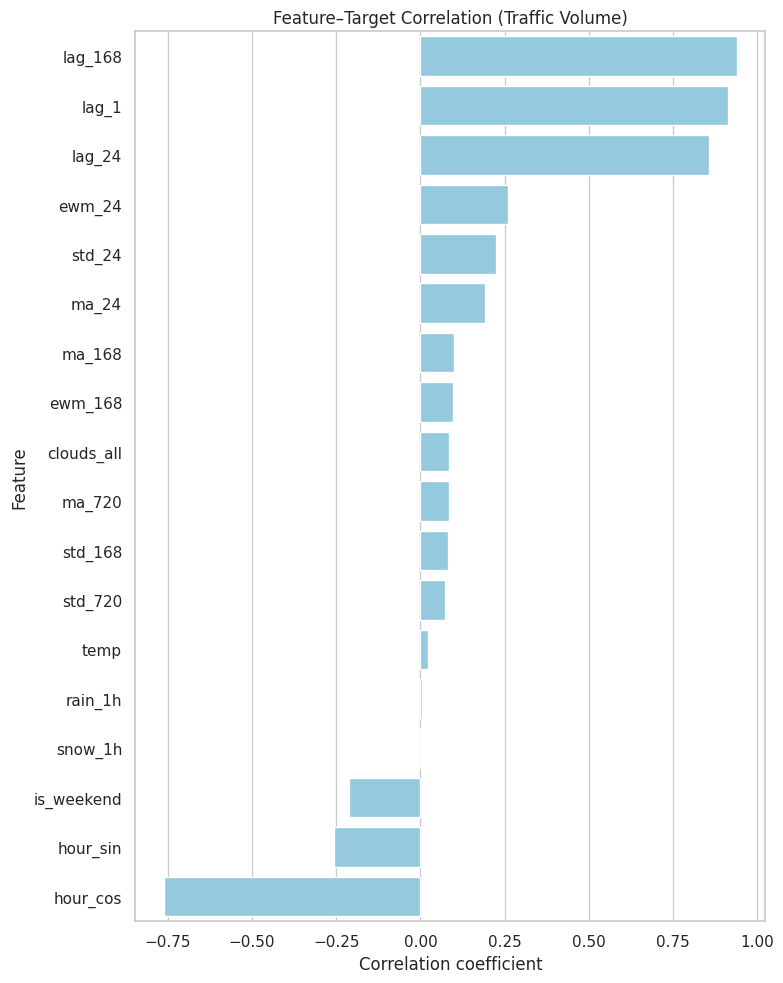

In [ ]:
# -------------------------------------------------------------------------
# ⚙️ Feature Engineering Pipeline for Traffic Forecasting (Colab Friendly)
# -------------------------------------------------------------------------
# This script constructs predictive features for time series modeling.
# It includes lag-based temporal features, moving averages, exponential
# smoothing, calendar encodings, and weather-based exogenous variables.
# -------------------------------------------------------------------------

import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# 1️⃣  Function: build_features(df)
# ---------------------------------------------------------------------
# Takes a cleaned traffic dataset and returns:
#    X_f → feature matrix (model inputs)
#    y_f → target series (traffic volume)
# Includes:
#   - Lag, rolling, and EWMA temporal features
#   - Calendar/time-based signals (sin/cos hour, weekday/weekend, holiday)
#   - Weather and external categorical encodings
# ---------------------------------------------------------------------
def build_features(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    s = df["traffic_volume"]

    # -----------------------------------------------------------------
    # 2️⃣  Temporal Lag & Rolling Features
    # -----------------------------------------------------------------
    # Adds time-shifted versions of traffic volume to capture past influence.
    # Includes:
    #   - Lags (1h, 24h, 168h)
    #   - Moving averages & std (24h, 168h, 720h)
    #   - Exponential weighted means (24h, 168h)
    # -----------------------------------------------------------------
    def add_lag_features(s, lags=(1, 24, 168), mas=(24, 168, 720), ewm_spans=(24, 168)):
        Xn = pd.DataFrame(index=s.index)

        # ---- Lag features ----
        for L in lags:
            Xn[f"lag_{L}"] = s.shift(L)

        # ---- Rolling mean and std ----
        for W in mas:
            Xn[f"ma_{W}"]  = s.shift(1).rolling(W).mean()   # mean over last W hours
            Xn[f"std_{W}"] = s.shift(1).rolling(W).std()    # std deviation

        # ---- Exponentially Weighted Moving Average ----
        for E in ewm_spans:
            Xn[f"ewm_{E}"] = s.shift(1).ewm(span=E, adjust=False).mean()

        return Xn

    X_num = add_lag_features(s)

    # -----------------------------------------------------------------
    # 3️⃣  Calendar & Exogenous Features
    # -----------------------------------------------------------------
    # Uses available numeric/exogenous columns from the dataset.
    # Weather, temporal sin/cos, holidays, and weekend indicators included.
    # -----------------------------------------------------------------
    use_cols = []
    for c in [
        "temp", "rain_1h", "snow_1h", "clouds_all",
        "hour_sin", "hour_cos", "is_weekend", "is_holiday",
        "is_tv_outlier", "dow"
    ]:
        if c in df.columns:
            use_cols.append(c)

    base = df[use_cols].copy()

    # -----------------------------------------------------------------
    # 4️⃣  Categorical Encodings (One-Hot)
    # -----------------------------------------------------------------
    # Converts categorical variables (weather, day-of-week) into one-hot vectors.
    # Keeps all categories (drop_first=False) to retain full signal.
    # -----------------------------------------------------------------
    X_cat_list = []

    # ---- Weather condition ----
    if "weather_main" in df.columns:
        wm = pd.get_dummies(df["weather_main"].fillna("Unknown"),
                            prefix="wm", drop_first=False)
        X_cat_list.append(wm)

    # ---- Day of week one-hot (optional) ----
    dow_oh = pd.get_dummies(df["dow"], prefix="dow", drop_first=False)
    X_cat_list.append(dow_oh)

    # Combine all categorical encodings
    X_cat = pd.concat(X_cat_list, axis=1) if len(X_cat_list) else pd.DataFrame(index=df.index)

    # -----------------------------------------------------------------
    # 5️⃣  Combine All Feature Sets
    # -----------------------------------------------------------------
    # Concatenate numeric, base exogenous, and categorical features.
    # Target variable (y) is the current hour’s traffic volume.
    # -----------------------------------------------------------------
    X = pd.concat([X_num, base, X_cat], axis=1)
    y = s

    # -----------------------------------------------------------------
    # 6️⃣  Clean-up and Output
    # -----------------------------------------------------------------
    # Drop NaNs created by lagging and rolling operations.
    # Returns final feature matrix (X_f) and aligned target (y_f).
    # -----------------------------------------------------------------
    data = pd.concat([X, y], axis=1).dropna()
    X_f = data.drop(columns=["traffic_volume"])
    y_f = data["traffic_volume"]

    return X_f, y_f


# ---------------------------------------------------------------------
# 7️⃣  Build Feature Matrix from Cleaned Dataset
# ---------------------------------------------------------------------
X_f, y_f = build_features(cleaned_df)

# Print shapes and sample columns for verification
print("✅ Features shape:", X_f.shape, "| Target shape:", y_f.shape)
print("🧩 Sample feature columns:", list(X_f.columns)[:15])

# -------------------------------------------------------------------------
# ⚖️ Feature Scaling and Importance Analysis (Colab Friendly)
# -------------------------------------------------------------------------
# After feature engineering, this section standardizes numeric columns
# and visualizes which features are most correlated or important for
# predicting traffic volume.
# -------------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

# ---------------------------------------------------------------------
# 8️⃣  Feature Scaling
# ---------------------------------------------------------------------
# Standardize numeric features to zero mean and unit variance.
# This is crucial for models like linear regression, LSTM, etc.
# Tree-based models (like RandomForest/XGBoost) don’t require it,
# but it’s often useful for consistency and inspection.
# ---------------------------------------------------------------------
scaler = StandardScaler()

# Select numeric columns only
num_cols = X_f.select_dtypes(include=["float64", "int64"]).columns

# Fit and transform
X_scaled = X_f.copy()
X_scaled[num_cols] = scaler.fit_transform(X_f[num_cols])

print(f"✅ Scaled {len(num_cols)} numeric features.")
print("Sample scaled features:")
display(X_scaled[num_cols].head())

# ---------------------------------------------------------------------
# 9️⃣  Correlation with Target (Warning-free)
# ---------------------------------------------------------------------
# Remove constant columns to avoid divide-by-zero in correlation
num_cols_valid = [c for c in num_cols if X_f[c].std() > 0]

corr_with_target = X_f[num_cols_valid].corrwith(y_f).dropna().sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_with_target.values,
    y=corr_with_target.index,
    color="skyblue"
)
plt.title("Feature–Target Correlation (Traffic Volume)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 🔟  Model-Based Feature Importance (Warning-Free)
# ---------------------------------------------------------------------
# Uses RandomForestRegressor to estimate which features most influence
# predicted traffic volume. Helps understand non-linear dependencies.
# ---------------------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_f.fillna(0), y_f)

# Extract and sort feature importances
importances = pd.Series(rf.feature_importances_, index=X_f.columns).sort_values(ascending=False)

# Select top 20
top_features = importances.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color="seagreen")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

print("✅ Feature importance computed using RandomForestRegressor.")

# ---------------------------------------------------------------------
# 1️⃣1️⃣  (Optional) Save for Modeling
# ---------------------------------------------------------------------
# Store processed data for downstream model training or tuning.
# ---------------------------------------------------------------------
X_scaled.to_parquet("traffic_features_scaled.parquet")
y_f.to_csv("traffic_target.csv", index=False)
print("💾 Saved scaled features and target for modeling.")

🧭 **Section Summary – Feature Engineering Insights**

  **Purpose:**  
  Transform the cleaned dataset into a predictive feature space that captures **temporal behavior, seasonal effects,** and **external influences** — while ensuring strict prevention of data leakage.

🌐 **Key Takeaways**

🔹 **Temporal Dynamics:**
Lag, rolling, and exponentially weighted features encode short-term memory, daily/weekly recurrences, and smooth long-term trends.

🔹 **Cyclical & Calendar Awareness:**
Sine–cosine time encoding, weekday/weekend flags, and holiday indicators allow models to learn natural traffic cycles effectively.

🔹 **Exogenous Drivers:**
Weather-related inputs (temperature, rain, snow, clouds) introduce environmental realism that improves generalization and responsiveness.

🔹 **Outlier Sensitivity:**
Anomaly indicators ensure robustness against irregular spikes or data glitches.

🔹 **Model Readiness:**
All features are lag-safe, standardized, and suitable for regression, tree-based, or sequence models — ensuring interpretability and scalability.





# 🔽 **➡️ Transition to Phase III: Modeling Strategy**


In this phase, we conducted a structured and rigorous preparation of the dataset to ensure its suitability for downstream predictive modeling.
Our workflow encompassed three critical components: data cleaning, exploratory data analysis (EDA), and feature engineering.

🧹 Data Cleaning

We addressed missing values, standardized temporal formats, and identified irregular entries to minimize noise and ensure data integrity. These steps were essential for establishing a reliable analytical foundation and preventing distortions in the modeling process.

🔍 Exploratory Data Analysis

The EDA revealed several key behavioral patterns in traffic volume:

Temporal seasonality across hours, days, and months

Weekday–weekend variability in traffic flow

Influence of holidays and weather conditions on volume fluctuations

These insights guided the design of predictive features and highlighted important external drivers affecting traffic behavior.

🏗️ Feature Engineering

We transformed raw timestamps into interpretable temporal features and applied cyclical encodings (e.g., sine/cosine transformations) to preserve natural periodicity in time-based patterns.
Additional contextual features relating to weather and holiday effects were engineered to support a richer representation of real-world conditions.

**🎯 Final Remarks**

Collectively, these steps resulted in a well-structured, noise-reduced, and context-rich dataset, optimized for learning meaningful traffic volume patterns. The dataset is now ready for Phase III, which will focus on:

Model selection and training

Hyperparameter tuning

Performance evaluation and validation

Interpretation of predictive behavior

This foundation ensures that the modeling phase will be empirically grounded, aligned with domain context, and able to produce results that are both accurate and explainable.
